In [18]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

In [2]:
x_train = catalog.load('uci_protein_1.x_train')
y_train = catalog.load('uci_protein_1.y_train')

x_test = catalog.load('uci_protein_1.x_test')
y_test = catalog.load('uci_protein_1.y_test')
model = catalog.load('uci_protein_1.model')

2022-01-17 07:07:20,880 - kedro.io.data_catalog - INFO - Loading data from `uci_protein_1.x_train` (UCIDataSet)...
2022-01-17 07:07:21,361 - kedro.io.data_catalog - INFO - Loading data from `uci_protein_1.y_train` (UCIDataSet)...
2022-01-17 07:07:21,846 - kedro.io.data_catalog - INFO - Loading data from `uci_protein_1.x_test` (UCIDataSet)...
2022-01-17 07:07:22,229 - kedro.io.data_catalog - INFO - Loading data from `uci_protein_1.y_test` (UCIDataSet)...
2022-01-17 07:07:22,611 - kedro.io.data_catalog - INFO - Loading data from `uci_protein_1.model` (TFBoostDataSet)...


In [3]:
model_tree = catboost.CatBoostRegressor(loss_function='RMSEWithUncertainty')
model_tree.fit(x_train, y_train, verbose=False)

In [16]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [12]:
calculate_nll(model, x_train, y_train, batch_size = 512)

1.7185029

In [13]:
calculate_nll(model, x_test, y_test, batch_size = 512)

2.0223062

In [19]:
calculate_nll_catboost(model_tree, x_train, y_train)

2.5435415254726155

In [20]:
calculate_nll_catboost(model_tree, x_test, y_test)

2.7918024313225827

In [4]:
y_test_catboost = model_tree.predict(x_test)
y_test_catboost_treeflow = model.tree_model.predict(x_test)

y_test_samples = model.sample(x_test, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

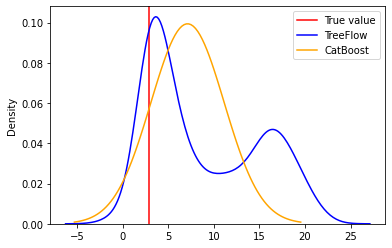

In [26]:
i = 0

plt.axvline(x=y_test.values[i, :], color='r', label='True value')

sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

x = np.linspace(
    stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    100
)
plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

plt.legend()
plt.savefig('protein_multimodal_1.pdf')

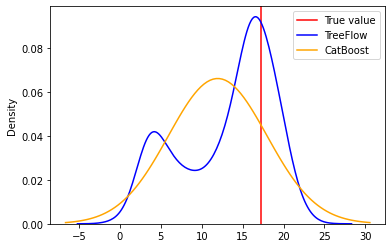

In [24]:
i = 15

plt.axvline(x=y_test.values[i, :], color='r', label='True value')

sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

x = np.linspace(
    stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    100
)
plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

plt.legend()
plt.savefig('protein_multimodal_2.pdf')